In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp


In [2]:
pyro.set_rng_seed(2021)
print(pyro.__version__)

1.6.0


In [3]:
def f(x):
    return (6 * x - 2)**2 * torch.sin(12 * x - 4)

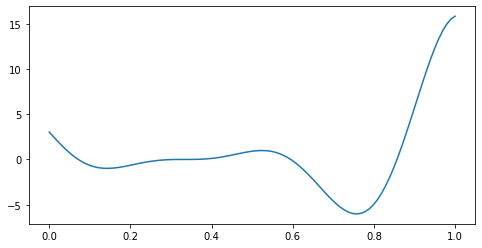

In [4]:
x = torch.linspace(0, 1, steps=100)
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), f(x).numpy())
plt.show()

In [6]:
def update_posterior(x_new):
    y = f(x_new) # evaluate f at new point.
    X = torch.cat([gpmodel.X, x_new]) # incorporate new evaluation
    y = torch.cat([gpmodel.y, y])
    gpmodel.set_data(X, y)
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    gp.util.train(gpmodel, optimizer)

## Define an acquisition function

In [24]:
if y.min() > 2:
    print(2)

In [7]:
def lower_confidence_bound(x, kappa=2):
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    return mu - kappa * sigma

In [8]:
def find_a_candidate(x_init, lower_bound=0, upper_bound=1):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lower_bound, upper_bound)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    minimizer = optim.LBFGS([unconstrained_x], line_search_fn='strong_wolfe')

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

In [9]:
def next_x(lower_bound=0, upper_bound=1, num_candidates=5):
    candidates = []
    values = []

    x_init = gpmodel.X[-1:]
    for i in range(num_candidates):
        x = find_a_candidate(x_init, lower_bound, upper_bound)
        y = lower_confidence_bound(x)
        candidates.append(x)
        values.append(y)
        x_init = x.new_empty(1).uniform_(lower_bound, upper_bound)

    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    return candidates[argmin]

In [36]:
def plot(gs, xmin, xlabel=None, with_title=True):
    xlabel = "xmin" if xlabel is None else "x{}".format(xlabel)
    Xnew = torch.linspace(-0.1, 1.1)
    ax1 = plt.subplot(gs[0])
    ax1.plot(gpmodel.X.numpy(), gpmodel.y.numpy(), "kx")  # plot all observed data
    with torch.no_grad():
        loc, var = gpmodel(Xnew, full_cov=False, noiseless=False)
        sd = var.sqrt()
        ax1.plot(Xnew.numpy(), loc.numpy(), "r", lw=2)  # plot predictive mean
        ax1.fill_between(Xnew.numpy(), loc.numpy() - 2*sd.numpy(), loc.numpy() + 2*sd.numpy(),
                         color="C0", alpha=0.3)  # plot uncertainty intervals
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_title("Find {}".format(xlabel))
    if with_title:
        ax1.set_ylabel("GP")

    ax2 = plt.subplot(gs[1])
    with torch.no_grad():
        # plot the acquisition function
        ax2.plot(Xnew.numpy(), lower_confidence_bound(Xnew).numpy())
        # plot the new candidate point
        ax2.plot(xmin.numpy(), lower_confidence_bound(xmin).numpy(), "^", markersize=10,
                 label="{} = {:.5f}".format(xlabel, xmin.item()))
    ax2.set_xlim(-0.1, 1.1)
    if with_title:
        ax2.set_ylabel("Acquisition Function")
    ax2.legend(loc=1)

In [46]:
%matplotlib

Using matplotlib backend: nbAgg


In [50]:
# initialize the model with four input points: 0.0, 0.33, 0.66, 1.0
X = torch.tensor([0.0, 0.33, 0.66, 1.0])
y = f(X)
gpmodel = gp.models.GPRegression(X, y, gp.kernels.Matern52(input_dim=1),
                                 noise=torch.tensor(0.1), jitter=1.0e-4)

<IPython.core.display.Javascript object>


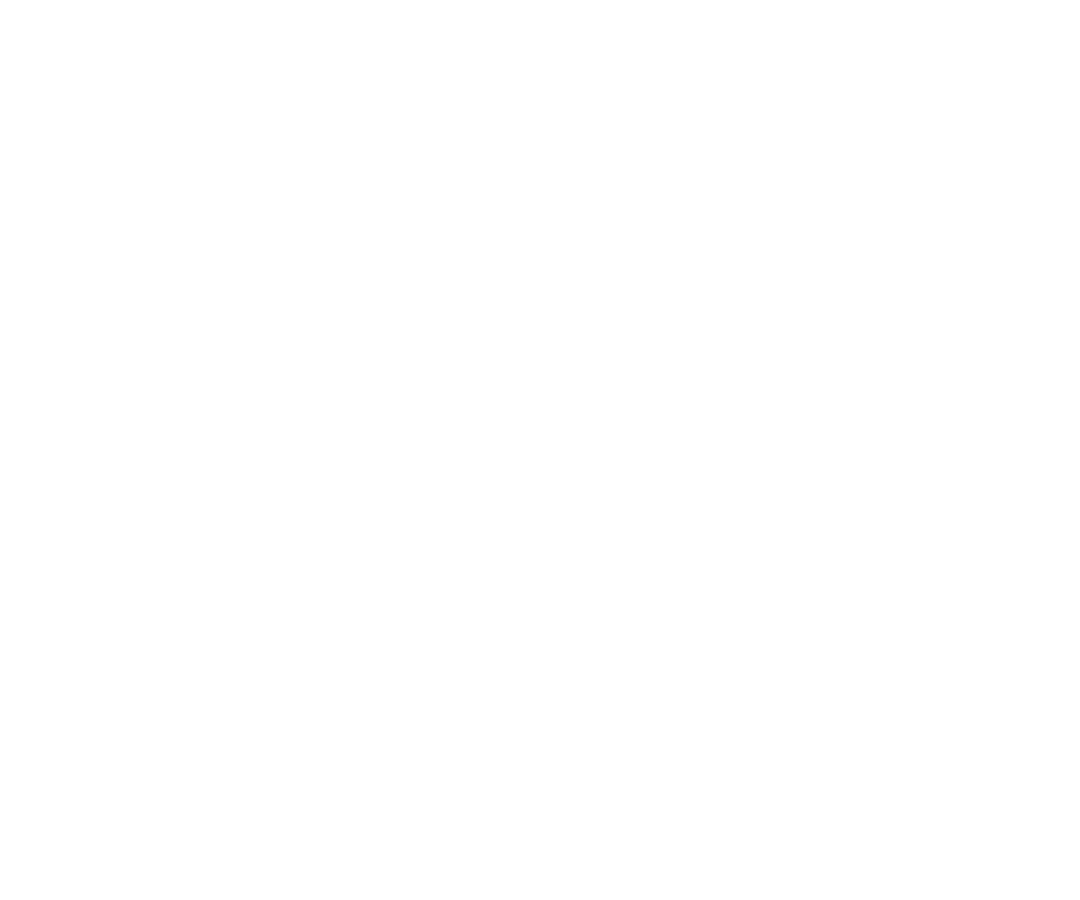

<IPython.core.display.Javascript object>


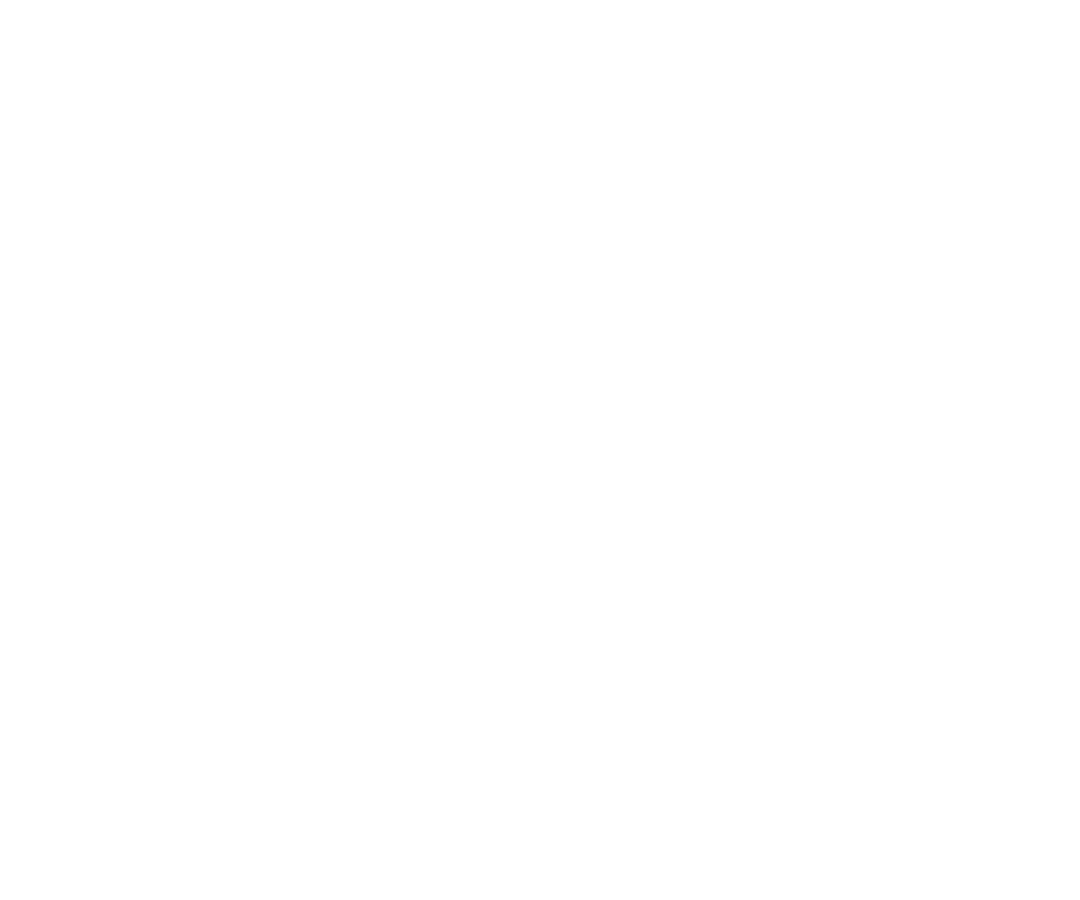

<IPython.core.display.Javascript object>


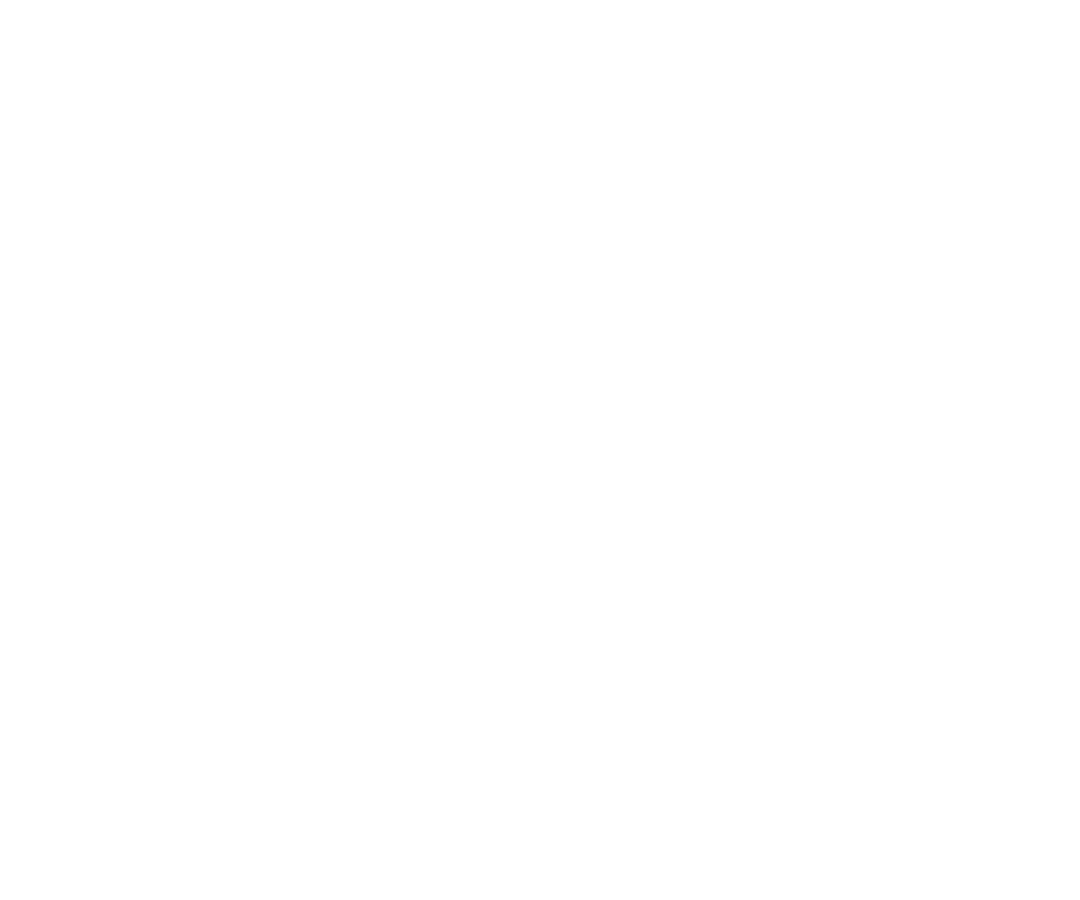

<IPython.core.display.Javascript object>


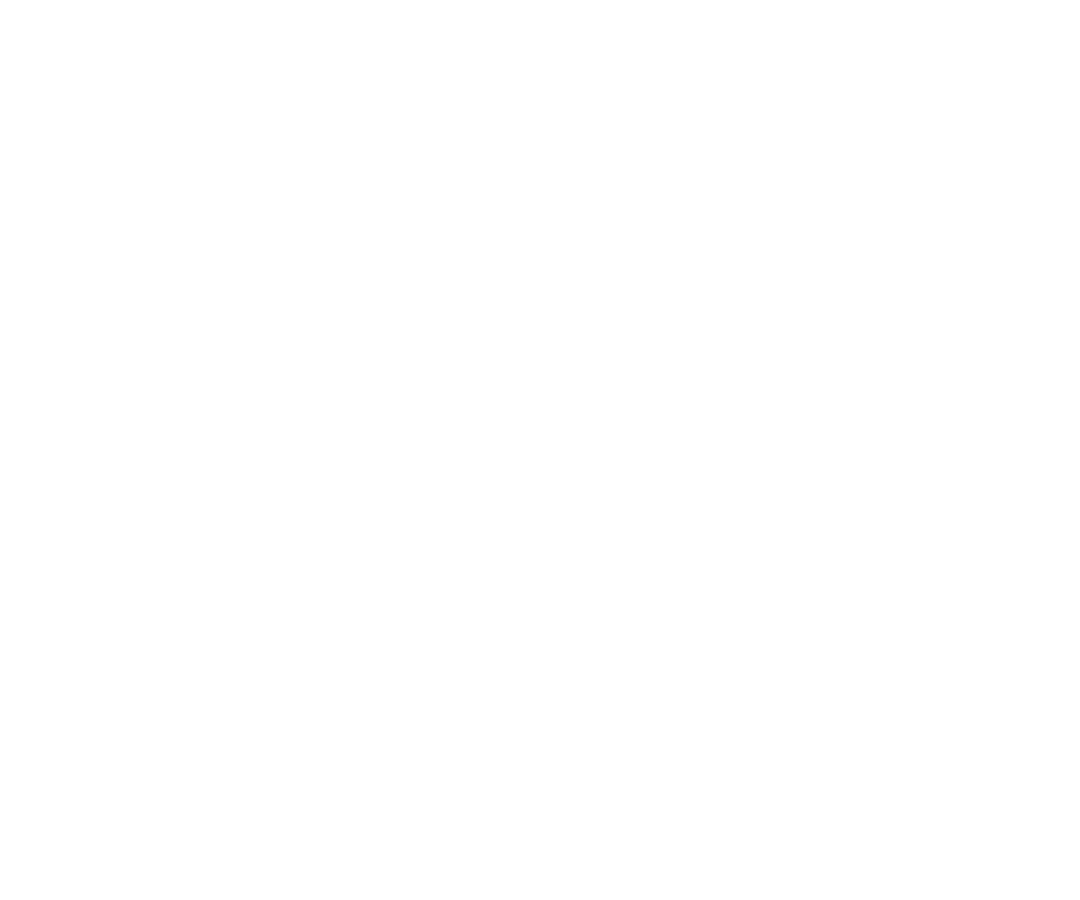

<IPython.core.display.Javascript object>


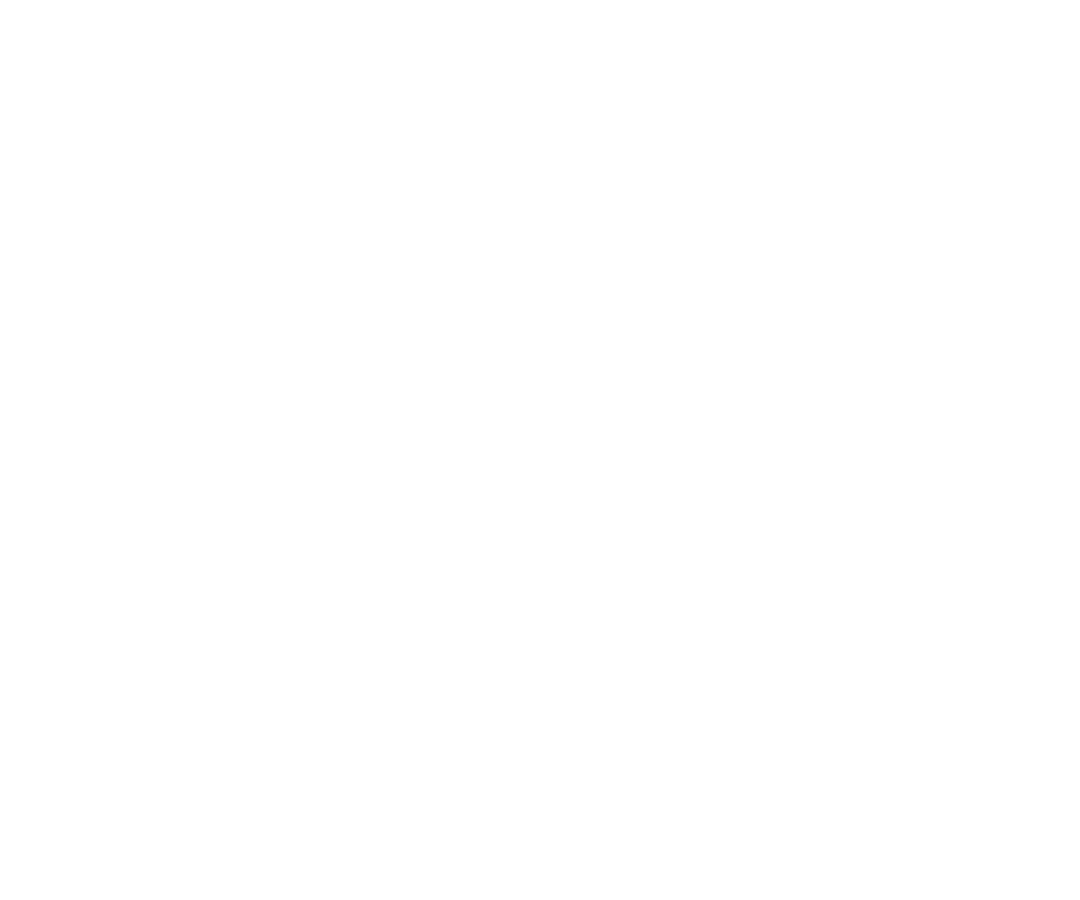

CPU times: user 10min 42s, sys: 23.9 s, total: 11min 6s
Wall time: 18.6 s


In [51]:
%%time

optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in range(5):
    xmin = next_x()
    plt.figure(figsize=(6, 5))
    gs = gridspec.GridSpec(2, 1)
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
    plt.savefig(f'images/iter{i}.png', dpi=200, facecolor='white', transparent=False)
    plt.close()



%%time
plt.figure(figsize=(12, 30))
outer_gs = gridspec.GridSpec(5, 2)
optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)
for i in range(8):
    xmin = next_x()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[i])
    plot(gs, xmin, xlabel=i+1, with_title=(i % 2 == 0))
    update_posterior(xmin)
plt.show()
